# Rekko challenge 2019

```
                           /$$$$$$$  /$$$$$$$$ /$$   /$$ /$$   /$$  /$$$$$$ 
                          | $$__  $$| $$_____/| $$  /$$/| $$  /$$/ /$$__  $$
                          | $$  \ $$| $$      | $$ /$$/ | $$ /$$/ | $$  \ $$
                          | $$$$$$$/| $$$$$   | $$$$$/  | $$$$$/  | $$  | $$
                          | $$__  $$| $$__/   | $$  $$  | $$  $$  | $$  | $$
                          | $$  \ $$| $$      | $$\  $$ | $$\  $$ | $$  | $$
                          | $$  | $$| $$$$$$$$| $$ \  $$| $$ \  $$|  $$$$$$/
                          |__/  |__/|________/|__/  \__/|__/  \__/ \______/ 
                                                                            
```

Добро пожаловать на соревнование по машинному обучению от онлайн-кинотеатра [Okko](http://okko.tv) Rekko Challenge 2019.

В этом ноутбуке мы покажем вам пример простого но полного решения, от загрузки данных до формирования ответа. Для работы нам понадобятся библиотеки `pandas`, `numpy`, `scipy`, `implicit`, `pprint`, `tqdm`. Установить их в вашем рабочем окружении можно следующей командой.
```
pip install pandas numpy scipy implicit pprint tqdm
```

In [1]:
import os
import json
import pandas as pd
import numpy as np
import tqdm
import scipy.sparse as sp

from pprint import pprint

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

Замените `DATA_PATH` на путь к данным, которые вы скачали со страницы соревнования.

In [2]:
DATA_PATH = './'

---

`catalogue.json` содержит анонимизированную метаинформацию о доступных в сервисе фильмах и сериалах.

In [13]:
with open(os.path.join(DATA_PATH, 'catalogue.json'), 'r') as f:
    catalogue = json.load(f)
    
catalogue = {int(k): v for k, v in catalogue.items()}

In [15]:
len(catalogue)

10200

In [16]:
pprint(catalogue[100])

{'attributes': [18441,
                16300,
                16580,
                18770,
                18771,
                18643,
                396,
                18772,
                3771,
                18773,
                910,
                18774,
                16364,
                3277],
 'availability': ['purchase', 'rent'],
 'duration': 80,
 'feature_1': 6064738.740195342,
 'feature_2': 0.752750538,
 'feature_3': 4,
 'feature_4': 0.9537104605,
 'feature_5': 0.0,
 'type': 'movie'}


 - `attributes` — мешок атрибутов
 - `availability` — доступность (может содержать значения `purchase`, `rent` и `subscription`)
 - `duration` — длительность в минутах, округлённая до десятков (продолжительность серии для сериалов и многосерийных фильмов)
 - `feature_1..5` — пять анонимизированных вещественных и порядковых признаков
 - `type` — принимает значения `movie`, `multipart_movie` или `series`

---

`test_users.json` содержит список пользователей, для которых необходимо построить предсказание

In [17]:
with open(os.path.join(DATA_PATH, 'test_users.json'), 'r') as f:
    test_users = set(json.load(f)['users'])

---

`transactions.csv` — список всех транзакций за определённый период времени

In [3]:
%%time
transactions = pd.read_csv(
    os.path.join(DATA_PATH, 'transactions.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

CPU times: user 11.5 s, sys: 371 ms, total: 11.9 s
Wall time: 12.3 s


In [19]:
transactions.head(3)

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer
0,3336,5177,S,4.430518e+07,4282,0,50
1,481,593316,S,4.430518e+07,2989,0,11
2,4128,262355,S,4.430518e+07,833,0,50


In [21]:
transactions.groupby(['user_uid', 'element_uid']).size().max()

1

In [20]:
transactions.user_uid.nunique()

499663

 - `element_uid` — идентификатор элемента
 - `user_uid` — идентификатор пользователя
 - `consumption_mode` — тип потребления (`P` — покупка, `R` — аренда, `S` — просмотр по подписке)
 - `ts` — время совершения транзакции или начала просмотра в случае просмотра по подписке
 - `watched_time` — число просмотренных по транзакции секунд
 - `device_type` — анонимизированный тип устройства, с которого была совершена транзакция или начат просмотр
 - `device_manufacturer` — анонимизированный производитель устройства, с которого была совершена транзакция или начат просмотр

---

`ratings.csv` содержит информацию о поставленных пользователями оценках

In [4]:
%%time
ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'ratings.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64,
        'rating': np.uint8
    }
)

CPU times: user 376 ms, sys: 8.03 ms, total: 384 ms
Wall time: 395 ms


In [23]:
ratings.head(3)

,user_uid,element_uid,rating,ts
0,571252,1364,10,4.430517e+07
1,63140,3037,10,4.430514e+07
2,443817,4363,8,4.430514e+07


In [24]:
ratings.user_uid.nunique()

104563

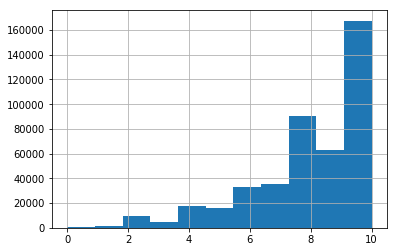

In [25]:
ratings.rating.hist(bins = 11);

 - `rating` — поставленный пользователем рейтинг (от `0` до `10`)

---

`bookmarks.csv` содержит информацию об элементах, добавленных пользователями в список «Избранное»

In [26]:
%%time
bookmarks = pd.read_csv(
    os.path.join(DATA_PATH, 'bookmarks.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64
    }
)

CPU times: user 411 ms, sys: 25.8 ms, total: 437 ms
Wall time: 482 ms


In [27]:
bookmarks.head(3)

,user_uid,element_uid,ts
0,301135,7185,4.430516e+07
1,301135,4083,4.430516e+07
2,301135,10158,4.430516e+07


In [28]:
bookmarks.element_uid.nunique()

9489

In [79]:
bookmarks_ext = bookmarks.merge(ratings, how = 'left', on = ['user_uid', 'element_uid'])

In [80]:
bookmarks_ext.head()

,user_uid,element_uid,ts_x,rating,ts_y
0,301135,7185,4.430516e+07,NaN,NaN
1,301135,4083,4.430516e+07,NaN,NaN
2,301135,10158,4.430516e+07,NaN,NaN
3,301135,2693,4.430516e+07,NaN,NaN
4,301135,2181,4.430515e+07,NaN,NaN


In [81]:
bookmarks_ext[bookmarks_ext.rating.notnull()].shape

(31350, 5)

In [82]:
bookmarks_ext['rating_new'] = 10

In [100]:
ratings_add = bookmarks_ext.loc[bookmarks_ext.rating.isnull(), ['user_uid', 'element_uid', 'rating_new', 'ts_x']]
ratings_add.columns = ['user_uid', 'element_uid', 'rating', 'ts']

In [111]:
ratings_add.user_uid = ratings_add.user_uid.astype(uint32)
ratings_add.element_uid = ratings_add.element_uid.astype(uint16)

In [112]:
ratings.dtypes

user_uid        uint32
element_uid     uint16
rating           uint8
ts             float64
dtype: object

In [114]:
ratings_ext.shape

(1355656, 4)

In [113]:
ratings_ext = pd.concat((ratings, ratings_add))

In [116]:
ratings_ext.head()

user_uid        uint32
element_uid     uint16
rating           int64
ts             float64
dtype: object

In [5]:
#bookmarks_users = set(bookmarks.user_uid.unique())
ratings_users = set(ratings.user_uid.unique())
transactions_users = set(transactions.user_uid.unique())

In [7]:
ratings_movies = set(ratings.element_uid.unique())
transactions_movies = set(transactions.element_uid.unique())

In [8]:
len(ratings_movies | transactions_movies)

8670

In [54]:
test_users <= transactions_users | ratings_users

True

### Решение

Для начала построим список элементов, которые тестовые пользователи уже купили или посмотрели по подписке: они не смогут купить их второй раз, а просмотр по подписке второй раз маловероятен, поэтому мы захотим отфильтровать такие элементы из финального ответа.

Точно так же можно поступить и с рейтингами и добавлениями в избранное, если это будет казаться правильным.

In [45]:
from collections import defaultdict

filtered_elements = defaultdict(set)

for user_uid, element_uid in tqdm.tqdm(transactions.loc[:, ['user_uid', 'element_uid']].values):
    if user_uid not in test_users:
        continue
    filtered_elements[user_uid].add(element_uid)

100%|██████████| 9643012/9643012 [00:29<00:00, 323139.30it/s]


In [133]:
trans_test = transactions[transactions.user_uid.isin(test_users)]

In [139]:
trans_test.groupby('user_uid').size().sort_values(ascending = False)

user_uid
320337    563
274419    517
97698     472
233721    463
279742    427
493223    408
452061    398
25527     384
412115    358
587537    349
214558    344
27639     335
320177    332
86835     331
532629    329
195807    327
371519    317
453564    316
162850    316
69880     313
530006    309
529717    308
296763    303
93609     302
31646     297
526549    296
474711    295
83325     293
291577    292
432206    289
         ... 
100896      2
568554      2
551996      2
350658      2
430610      2
512662      2
540970      2
479679      2
253663      2
212889      2
350312      2
148841      2
42242       2
78305       2
184950      1
81069       1
163715      1
313055      1
378780      1
58835       1
281061      1
109486      1
28829       1
226422      1
147741      1
528981      1
534077      1
245100      1
325181      1
254476      1
Length: 49992, dtype: int64

---

Для примера мы воспользуемся методом K ближайших соседей, реализованным в библиотеке `implicit`. В качестве данных используем только информацию о рейтингах.

Необходимо построить разреженную матрицу, где строкам будут соответствовать элементы, столбцам — пользователи, а на пересечении пользователя и элемента будет находиться количественная оценка степени их взаимодействия, если таковое имело место.

Не забудем добавить `1` к рейтингу, чтобы избежать деления на ноль во время вычисления `tf-idf`.

In [117]:
ratings = ratings_ext

In [51]:
ratings['user_uid'] = ratings['user_uid'].astype('category')
ratings['element_uid'] = ratings['element_uid'].astype('category')

ratings_matrix = sp.coo_matrix(
    (ratings['rating'].astype(np.float32) + 1,
        (
            ratings['element_uid'].cat.codes.copy(),
            ratings['user_uid'].cat.codes.copy()
        )
    )
)

ratings_matrix = ratings_matrix.tocsr()

In [53]:
ratings_matrix

<7519x104563 sparse matrix of type '<class 'numpy.float32'>'
	with 438790 stored elements in Compressed Sparse Row format>

In [49]:
ratings['user_uid'].cat.categories.max()

593486

In [29]:
ratings['user_uid'] = ratings['user_uid'].astype('category')

In [119]:
sparsity = ratings_matrix.nnz / (ratings_matrix.shape[0] * ratings_matrix.shape[1])
print('Sparsity: %.6f' % sparsity)

Sparsity: 0.000697


Обучить модель крайне просто.

In [120]:
from implicit.nearest_neighbours import TFIDFRecommender

model = TFIDFRecommender()
model.fit(ratings_matrix)

100%|██████████| 9526/9526 [00:00<00:00, 10347.85it/s]


---

In [121]:
ratings_matrix_T = ratings_matrix.T.tocsr()

Отображения из оригинальной категории во внутреннюю пригодится нам в дальнейшем.

In [122]:
user_uid_to_cat = dict(zip(
    ratings['user_uid'].cat.categories,
    range(len(ratings['user_uid'].cat.categories))
))

In [123]:
element_uid_to_cat = dict(zip(
    ratings['element_uid'].cat.categories,
    range(len(ratings['element_uid'].cat.categories))
))

In [124]:
filtered_elements_cat = {k: [element_uid_to_cat.get(x, None) for x in v] for k, v in filtered_elements.items()}

---

В метод `model.recommend` мы передаём идентификатор пользователя, который получаем обратным преобразованием из категории, транспонированную матрицу взаимодействий, число необходимых рекомендаций и список элементов, которые мы договорились фильтровать из ответа.

Возвращает метод список пар (`element_cat`, `score`), отсортированный по вторым элементам. Из него необходимо достать все первые элементы пар и из категории преобразовать их к `element_uid`.

**Важно:** Не все тестовые пользователи есть в `ratings.csv` и не все из них есть в `transactions.csv`. Используя только один источник данных мы не можем построить полное предсказание. Такой ответ с неполным числом пользователей бдет принят системой, но при вычислении средней метрики метрика для отсутствующих пользователей будет принята равной нулю.

In [125]:
result = {}

for user_uid in tqdm.tqdm(test_users):
    # transform user_uid to model's internal user category
    try:
        user_cat = user_uid_to_cat[user_uid]
    except LookupError:
        continue
    
    # perform inference
    recs = model.recommend(
        user_cat,
        ratings_matrix_T,
        N=20,
        filter_already_liked_items=True,
        filter_items=filtered_elements_cat.get(user_uid, set())
    )
    
    # drop scores and transform model's internal elelemnt category to element_uid for every prediction
    # also convert np.uint64 to int so it could be json serialized later
    result[user_uid] = [int(ratings['element_uid'].cat.categories[i]) for i, _ in recs]

100%|██████████| 50000/50000 [00:15<00:00, 3184.83it/s]


In [126]:
len(result)

24568

Используя только информацию о рейтингах мы смогли построить предсказание для `13251` из `50000` тестовых пользователей. Ровно в таком виде ответы и стоит сохранить для отправки.

In [59]:
with open('answer.json', 'w') as f:
    json.dump(result, f)

----

In [127]:
top20_ratings = ratings.groupby('element_uid').size().sort_values(ascending = False)[:20].index

In [128]:
ratings_users = set(ratings.user_uid.unique())
bookmarks_users = set(bookmarks.user_uid.unique())
len(test_users - ratings_users - bookmarks_users)

25432

In [129]:
for user_uid in tqdm.tqdm(test_users - ratings_users - bookmarks_users):
    result[user_uid] = list(top20_ratings)

100%|██████████| 25432/25432 [00:10<00:00, 2487.81it/s]


In [130]:
with open('baseline_bookmarks10_top20.json', 'w') as f:
    json.dump(result, f)